# DSW export

In [6]:
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
from pathlib import Path

import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath
from IPython.display import display, Image

import netCDF4 as nc
import xarray as xr
import numpy as np
import xgcm
import calendar

from matplotlib import gridspec
from collections import OrderedDict

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [7]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45595/status,
Dashboard: /proxy/45595/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42405,Workers: 0
Dashboard: /proxy/45595/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45025,Total threads: 1
Dashboard: /proxy/34025/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:39223,


In [8]:
# Contour mask
contour_mask_1 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')
contour_mask_2 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')
isobath_depth = 1000
outfile = '/g/data/x77/cy8964/Post_Process/access-om2'+'/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
contour_mask_3 = np.load(outfile)

In [9]:
lat_slice = slice(-79,-59)
grid_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')
grid_005 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')
grid_acc = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')

In [10]:
# Grids and masks
grids = {'01deg': grid_01, '005deg': grid_005, 'access': grid_acc}
masks = {'01deg': contour_mask_1, '005deg': contour_mask_2, 'access': contour_mask_3}

# Dictionary to store results
contour_data = {}

for res in ['01deg', '005deg', 'access']:
    grid = grids[res]
    contour_mask = masks[res]

    if res == 'access':
        # ----- ACCESS -----
        # Load masks from .npz (numpy arrays)
        mask_y_transport = contour_mask['mask_y_transport']
        mask_x_transport = contour_mask['mask_x_transport']
        mask_y_transport_numbered = contour_mask['mask_y_transport_numbered']
        mask_x_transport_numbered = contour_mask['mask_x_transport_numbered']
    
        # Now get correct coordinate sizes
        yt_ocean = grid['yt_ocean'][:mask_x_transport.shape[0]]
        yu_ocean = grid['yu_ocean'][:mask_y_transport.shape[0]]
        xt_ocean = grid['xt_ocean'][:mask_y_transport.shape[1]]
        xu_ocean = grid['xu_ocean'][:mask_x_transport.shape[1]]
    
        # Build DataArrays (exactly as in your original code)
        mask_x_transport = xr.DataArray(mask_x_transport,
            coords=[yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
        mask_y_transport = xr.DataArray(mask_y_transport,
            coords=[yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
        mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,
            coords=[yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
        mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,
            coords=[yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

    else:   
        # ----- PanAnt -----
        yh = grid['yh'].sel(yh=lat_slice)
        yq = grid['yq'].sel(yq=lat_slice)
        xh = grid['xh']
        xq = grid['xq']

        # Select masks for this lat slice
        mask_y_transport = contour_mask['mask_y_transport'].sel(yq=lat_slice)
        mask_x_transport = contour_mask['mask_x_transport'].sel(yh=lat_slice)
        mask_y_transport_numbered = contour_mask['mask_y_transport_numbered'].sel(yq=lat_slice)
        mask_x_transport_numbered = contour_mask['mask_x_transport_numbered'].sel(yh=lat_slice)

        # Assign coordinates (same as your original)
        mask_x_transport = xr.DataArray(mask_x_transport,
            coords=[yh[:mask_x_transport.shape[0]], xq[:mask_x_transport.shape[1]]],
            dims=['y_ocean', 'x_ocean'])
        mask_y_transport = xr.DataArray(mask_y_transport,
            coords=[yq[:mask_y_transport.shape[0]], xh[:mask_y_transport.shape[1]]],
            dims=['y_ocean', 'x_ocean'])
        mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,
            coords=[yh[:mask_x_transport_numbered.shape[0]], xq[:mask_x_transport_numbered.shape[1]]],
            dims=['y_ocean', 'x_ocean'])
        mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,
            coords=[yq[:mask_y_transport_numbered.shape[0]], xh[:mask_y_transport_numbered.shape[1]]],
            dims=['y_ocean', 'x_ocean'])

    
    # --- Stack contour data into 1D (shared logic) ---
    mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index=['y_ocean', 'x_ocean'])
    mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop=True)
    mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index=['y_ocean', 'x_ocean'])
    mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop=True)

    contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim='contour_index')
    contour_ordering = contour_ordering.sortby(contour_ordering)
    contour_index_array = np.arange(1, len(contour_ordering) + 1)

    # --- Get lat/lon along contour ---
    lat_along_contour = contour_ordering.y_ocean
    lon_along_contour = contour_ordering.x_ocean
    lat_along_contour.coords['contour_index'] = contour_index_array
    lon_along_contour.coords['contour_index'] = contour_index_array

    # --- Save results ---
    contour_data[res] = {
        'lat': lat_along_contour,
        'lon': lon_along_contour,
        'contour_index': contour_index_array
    }


In [11]:
# Dictionary to store tickmark indices for both resolutions
distance_indices_all = {}

for res in ['01deg', '005deg', 'access']:
    lon_along_contour = contour_data[res]['lon']

    distance_indices = np.zeros(8, dtype=int)
    for i in np.arange(100, len(lon_along_contour.values)):
        if distance_indices[1] == 0 and lon_along_contour.values[i] > -240:
            distance_indices[1] = lon_along_contour.contour_index.values[i]
        if distance_indices[2] == 0 and lon_along_contour.values[i] > -180:
            distance_indices[2] = lon_along_contour.contour_index.values[i]
        if distance_indices[3] == 0 and lon_along_contour.values[i] > -120:
            distance_indices[3] = lon_along_contour.contour_index.values[i]
        if distance_indices[4] == 0 and lon_along_contour.values[i] > -60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
        if distance_indices[5] == 0 and lon_along_contour.values[i] > 0:
            distance_indices[5] = lon_along_contour.contour_index.values[i]
        if distance_indices[6] == 0 and lon_along_contour.values[i] > 60:
            distance_indices[6] = lon_along_contour.contour_index.values[i]

    distance_indices[7] = len(lon_along_contour.contour_index.values) - 1

    # Save for this resolution
    distance_indices_all[res] = distance_indices

In [12]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
# WAW = -150
# WAE = -65
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

In [13]:
# Dictionary to store basin indices for both resolutions
basin_indices_all = {}

# Define basin longitude thresholds (already defined in your script)
# AdelieE, RossE, AmE, BeE, WeddellE, PrydzE

for res in ['01deg', '005deg', 'access']:
    lon_along_contour = contour_data[res]['lon']

    basin_indices = np.zeros(7, dtype=int)
    for i in np.arange(100, len(lon_along_contour.values)):
        if basin_indices[1] == 0 and lon_along_contour.values[i] > AdelieE:
            basin_indices[1] = lon_along_contour.contour_index.values[i]
        if basin_indices[2] == 0 and lon_along_contour.values[i] > RossE:
            basin_indices[2] = lon_along_contour.contour_index.values[i]
        if basin_indices[3] == 0 and lon_along_contour.values[i] > AmE:
            basin_indices[3] = lon_along_contour.contour_index.values[i]
        if basin_indices[4] == 0 and lon_along_contour.values[i] > BeE:
            basin_indices[4] = lon_along_contour.contour_index.values[i]
        if basin_indices[5] == 0 and lon_along_contour.values[i] > WeddellE:
            basin_indices[5] = lon_along_contour.contour_index.values[i]
        if basin_indices[6] == 0 and lon_along_contour.values[i] > PrydzE:
            basin_indices[6] = lon_along_contour.contour_index.values[i]

    # Save for this resolution
    basin_indices_all[res] = basin_indices


In [14]:
# If already loaded, just use:
distance_along_contour_01 = xr.open_dataset('/g/data/x77/kc5856/Post_Process/panan-01/1000m_isobath_contour_distance.nc').distance_along_contour
distance_along_contour_005 = xr.open_dataset('/g/data/x77/kc5856/Post_Process/panan-005/1000m_isobath_contour_distance.nc').distance_along_contour
distance_along_contour_acc = xr.open_dataset('/g/data/x77/cy8964/Post_Process/access-om2/1000m_isobath_contour_distance.nc').distance_along_contour

In [15]:
Adelie = slice(basin_indices[0],basin_indices[1])
Ross = slice(basin_indices[1],basin_indices[2])
Am = slice(basin_indices[2],basin_indices[3])
Be = slice(basin_indices[3],basin_indices[4])
Weddell = slice(basin_indices[4], basin_indices[5])
Prydz = slice(basin_indices[5],None)

In [16]:
land_mask = np.squeeze(grid_01['deptho'].values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = grid_01['deptho'].yh.values
land_mask_lat[0] = -90

In [17]:
save_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/cross_slope_binned/'
file_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/plots/'

deptho = grid_01['deptho'].sel(yh=lat_slice)
yh = grid_01['yh'].sel(yh=lat_slice)
xh = grid_01['xh']

### Loading in the data

In [18]:
pan01_cont_circ = xr.open_dataset(file_dir+'Circumpolar_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Ade = xr.open_dataset(file_dir+'Adelie_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Ros = xr.open_dataset(file_dir+'Ross_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Am = xr.open_dataset(file_dir+'Amundsen_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Be = xr.open_dataset(file_dir+'Bellingshausen_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_We = xr.open_dataset(file_dir+'Weddell_Control_pan01_transport_profile.nc').to_array().squeeze()
pan01_cont_Pr = xr.open_dataset(file_dir+'Prydz_Control_pan01_transport_profile.nc').to_array().squeeze()

pan01_melt_circ = xr.open_dataset(file_dir+'Circumpolar_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Ade = xr.open_dataset(file_dir+'Adelie_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Ros = xr.open_dataset(file_dir+'Ross_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Am = xr.open_dataset(file_dir+'Amundsen_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Be = xr.open_dataset(file_dir+'Bellingshausen_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_We = xr.open_dataset(file_dir+'Weddell_Melt_pan01_transport_profile.nc').to_array().squeeze()
pan01_melt_Pr = xr.open_dataset(file_dir+'Prydz_Melt_pan01_transport_profile.nc').to_array().squeeze()

In [19]:
pan005_cont_circ = xr.open_dataset(file_dir+'Circumpolar_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Ade = xr.open_dataset(file_dir+'Adelie_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Ros = xr.open_dataset(file_dir+'Ross_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Am = xr.open_dataset(file_dir+'Amundsen_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Be = xr.open_dataset(file_dir+'Bellingshausen_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_We = xr.open_dataset(file_dir+'Weddell_Control_pan005_transport_profile.nc').to_array().squeeze()
pan005_cont_Pr = xr.open_dataset(file_dir+'Prydz_Control_pan005_transport_profile.nc').to_array().squeeze()

pan005_melt_circ = xr.open_dataset(file_dir+'Circumpolar_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Ade = xr.open_dataset(file_dir+'Adelie_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Ros = xr.open_dataset(file_dir+'Ross_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Am = xr.open_dataset(file_dir+'Amundsen_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Be = xr.open_dataset(file_dir+'Bellingshausen_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_We = xr.open_dataset(file_dir+'Weddell_Melt_pan005_transport_profile.nc').to_array().squeeze()
pan005_melt_Pr = xr.open_dataset(file_dir+'Prydz_Melt_pan005_transport_profile.nc').to_array().squeeze()

In [20]:
access_cont_circ = xr.open_dataset(file_dir+'Circumpolar_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Ade = xr.open_dataset(file_dir+'Adelie_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Ros = xr.open_dataset(file_dir+'Ross_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Am = xr.open_dataset(file_dir+'Amundsen_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Be = xr.open_dataset(file_dir+'Bellingshausen_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_We = xr.open_dataset(file_dir+'Weddell_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Pr = xr.open_dataset(file_dir+'Prydz_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()

access_melt_circ = xr.open_dataset(file_dir+'Circumpolar_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Ade = xr.open_dataset(file_dir+'Adelie_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Ros = xr.open_dataset(file_dir+'Ross_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Am = xr.open_dataset(file_dir+'Amundsen_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Be = xr.open_dataset(file_dir+'Bellingshausen_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_We = xr.open_dataset(file_dir+'Weddell_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Pr = xr.open_dataset(file_dir+'Prydz_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()

In [21]:
pan01_anom_circ = pan01_melt_circ - pan01_cont_circ
pan01_anom_Ade = pan01_melt_Ade - pan01_cont_Ade
pan01_anom_Ros = pan01_melt_Ros - pan01_cont_Ros
pan01_anom_Am = pan01_melt_Am - pan01_cont_Am
pan01_anom_Be = pan01_melt_Be - pan01_cont_Be
pan01_anom_We = pan01_melt_We - pan01_cont_We
pan01_anom_Pr = pan01_melt_Pr - pan01_cont_Pr

In [22]:
pan005_anom_circ = pan005_melt_circ - pan005_cont_circ
pan005_anom_Ade = pan005_melt_Ade - pan005_cont_Ade
pan005_anom_Ros = pan005_melt_Ros - pan005_cont_Ros
pan005_anom_Am = pan005_melt_Am - pan005_cont_Am
pan005_anom_Be = pan005_melt_Be - pan005_cont_Be
pan005_anom_We = pan005_melt_We - pan005_cont_We
pan005_anom_Pr = pan005_melt_Pr - pan005_cont_Pr

In [23]:
access_anom_circ = access_melt_circ - access_cont_circ
access_anom_Ade = access_melt_Ade - access_cont_Ade
access_anom_Ros = access_melt_Ros - access_cont_Ros
access_anom_Am = access_melt_Am - access_cont_Am
access_anom_Be = access_melt_Be - access_cont_Be
access_anom_We = access_melt_We - access_cont_We
access_anom_Pr = access_melt_Pr - access_cont_Pr

In [24]:
# Cumulative sums
pan01_cont_cumsum = xr.open_dataset(file_dir+'Control_pan01_cumulative_transport.nc')['Control_cumulative_transport']
pan01_melt_cumsum = xr.open_dataset(file_dir+'Melt_pan01_cumulative_transport.nc')['Melt_cumulative_transport']
pan01_anom_cumsum = pan01_melt_cumsum - pan01_cont_cumsum

pan005_cont_cumsum = xr.open_dataset(file_dir+'Control_pan005_cumulative_transport.nc')['Control_cumulative_transport']
pan005_melt_cumsum = xr.open_dataset(file_dir+'Melt_pan005_cumulative_transport.nc')['Melt_cumulative_transport']
pan005_anom_cumsum = pan005_melt_cumsum - pan005_cont_cumsum

access_cont_cumsum = xr.open_dataset(file_dir+'Control_prescribed_ACCESS_cumulative_transport.nc')['Control_cumulative_transport']
access_melt_cumsum = xr.open_dataset(file_dir+'Melt_prescribed_ACCESS_cumulative_transport.nc')['Melt_cumulative_transport']
access_anom_cumsum = access_melt_cumsum - access_cont_cumsum

In [28]:
# --- Colors and line styles ---
colors = {
    'control': 'k', 
    'melt': '#BB5566',
    'anom_01': '#0072B2', 
    'anom_005': '#D55E00',
    'anom_acc': '#D55E00',
    'pan01': '#0072B2',
    'pan005': '#D55E00',
    'access': '#D55E00'
}

linestyles = {
    'control': '--', 
    'melt': '-', 
    'anom_01': '-', 
    'anom_005': '-',
    'anom_acc': '-',
    'pan01': '-',
    'pan005':'-',
    'access':'-'
}
linewidths = {k: 2 for k in colors.keys()}
labels = {
    'control': 'Control', 
    'melt': 'Melt', 
    'anom_01': '0.1°', 
    'anom_005': '0.05°',
    'anom_acc': 'ACCESS-OM2',
    'pan01':'PanAnt. 0.1°',
    'pan005':'PanAnt. 0.05°',
    'access':'ACCESS-OM2'
}


# --- Sector names and letters (removed Amundsen + Bellingshausen) ---
sector_names = ['Circumpolar', 'Adelie', 'Ross', 'Weddell', 'Prydz']
letter_labels = ['a)', 'b)', 'c)', 'd)', 'e)']

# --- Data arrays (removed Am + Be entries) ---
sector_pan01_control = [pan01_cont_circ, pan01_cont_Ade, pan01_cont_Ros, pan01_cont_We, pan01_cont_Pr]
sector_pan01_melt    = [pan01_melt_circ, pan01_melt_Ade, pan01_melt_Ros, pan01_melt_We, pan01_melt_Pr]

sector_pan005_control = [pan005_cont_circ, pan005_cont_Ade, pan005_cont_Ros, pan005_cont_We, pan005_cont_Pr]
sector_pan005_melt    = [pan005_melt_circ, pan005_melt_Ade, pan005_melt_Ros, pan005_melt_We, pan005_melt_Pr]

sector_access_control = [access_cont_circ, access_cont_Ade, access_cont_Ros, access_cont_We, access_cont_Pr]
sector_access_melt    = [access_melt_circ, access_melt_Ade, access_melt_Ros, access_melt_We, access_melt_Pr]

sector_anoms_01 = [pan01_anom_circ, pan01_anom_Ade, pan01_anom_Ros, pan01_anom_We, pan01_anom_Pr]
sector_anoms_005 = [pan005_anom_circ, pan005_anom_Ade, pan005_anom_Ros, pan005_anom_We, pan005_anom_Pr]
sector_anoms_acc = [access_anom_circ, access_anom_Ade, access_anom_Ros, access_anom_We, access_anom_Pr]

# Plotting

In [29]:
# X-limits for control vs melt (rows 1 + 2)
xlims_ctrlmelt = {
    'Circumpolar': (-0.1, 8.6),
    'Adelie': (-2, 2),
    'Ross': (-0.1, 4.1),
    'Amundsen': (-0.4, 0.2),
    'Bellingshausen': (-0.3, 0.3),
    'Weddell': (-0.5, 3),
    'Prydz': (-0.1, 2.2)
}

# X-limits for anomalies (row 3)
xlims_anom = {
    'Circumpolar': (-1.6, 0.6),
    'Adelie': (-0.8, 0.2),
    'Ross': (-0.6, 0.2),
    'Amundsen': (-0.02, 0.1),
    'Bellingshausen': (-0.05, 0.4),
    'Weddell': (-1.1, 1),
    'Prydz': (-1, 0.5)
}

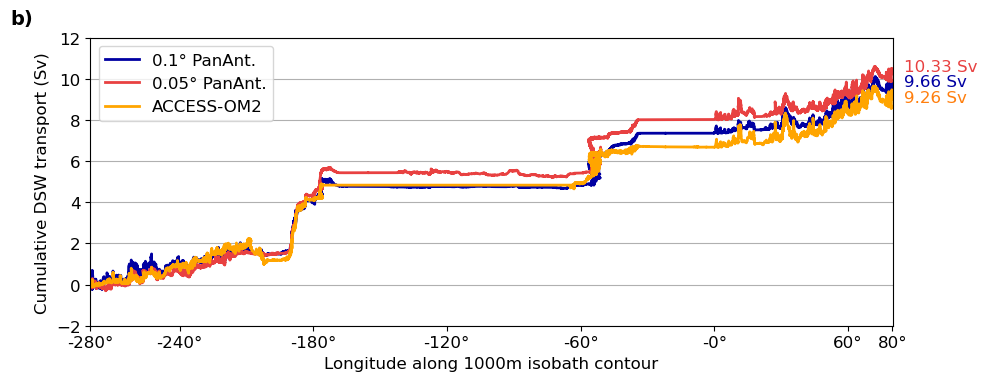

In [56]:
plt.rcParams['font.size'] = 12

# --- Plot config ---
#colors = {'Control_pan005': '#EB6841', 'Control_pan01' : '#792A07',  'Control_access': '#00A0B0'}
colors = {'Control_pan01': '#0000a2',
          'Control_pan005': '#E84141',
          'Control_access': 'orange'}
#colors = {'Control_pan005': '#7CC4FF', 'Control_pan01' : '#339E09',  'Control_access': '#332288'} #
colors_text = {'Control_pan01': '#0000a2', 'Control_pan005' : '#E84141',  'Control_access': 'tab:orange'}

linestyles = {'Control_pan01': '-', 
              'Control_pan005': '-',
              'Control_access': '-'}
labels = {'Control_pan01': '0.1° PanAnt.',
          'Control_pan005': '0.05° PanAnt.',
          'Control_access': 'ACCESS-OM2'}
line_offsets = {'Control_pan01': 0, 'Control_access':0, 'Control_pan005': 1.5}

# --- Define figure ---
fig, ax = plt.subplots(figsize=(10, 4))

# --- Plot each cumulative transport ---
for key, array, res in zip(
    ['Control_pan01', 'Control_pan005','Control_access'],
    [pan01_cont_cumsum, pan005_cont_cumsum,access_cont_cumsum],
    ['01deg', '005deg','access']
):
    # Select longitude array for this resolution
    lon_vals = contour_data[res]['lon']

    # Optional offset for label placement
    offset = 0 if 'pan01' in key else -0.4

    # Plot line
    ax.plot(lon_vals, array, label=labels[key],
            color=colors[key], linestyle=linestyles[key], linewidth=2)

    # Add text at the end of the line
    ax.text(lon_vals[-1] + 5, offset + array[-1] + 0.3 * line_offsets[key],
            f"{array[-1].values:.2f} Sv", color=colors_text[key], fontsize=12)


# --- Customize axes ---
ax.set_ylabel('Cumulative DSW transport (Sv)', fontsize=12)
ax.set_ylim(-2, 12)
ax.set_xlim(-280, 80)
ax.grid(axis='y')

# ✅ Use pan01 ticks/labels as reference
res_ref = '01deg'
indices = distance_indices_all[res_ref]
x_ticks = contour_data[res_ref]['lon'].values[indices]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{lon:.0f}°" for lon in x_ticks])

ax.set_xlabel('Longitude along 1000m isobath contour', fontsize=12)
ax.legend(loc='upper left')

ax.text(-0.1, 1.1, 'b)', transform=ax.transAxes,
         ha='left', va='top', fontsize=14, fontweight='bold')

plt.tight_layout()

fig.savefig("/g/data/g40/kc5856/thesis_figures/validation_DSWexport_finalcolours.png", dpi=300, bbox_inches='tight')

plt.show()


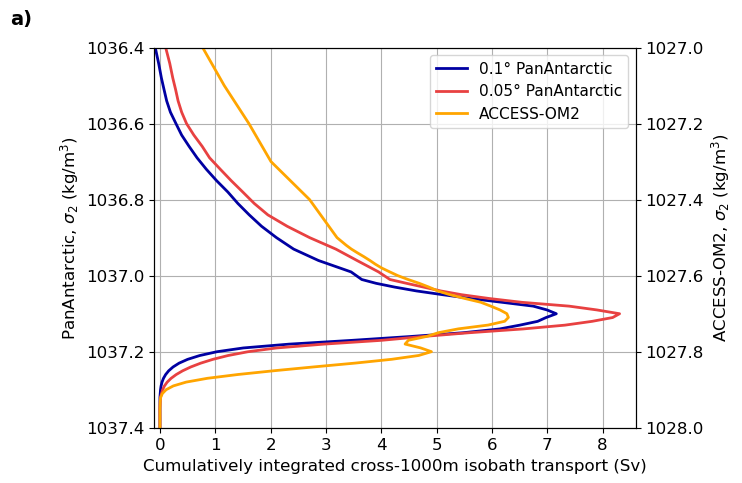

In [57]:
plt.rcParams['font.size'] = 12

fig, ax1 = plt.subplots(figsize=(8,5))

# Pick out Circumpolar only (col=0)
name = sector_names[0]  # "Circumpolar"

# --- Plot pan01 control ---
sector_pan01_control[0].plot(ax=ax1, y='rho2_l',
                             color=colors['Control_pan01'], linestyle='-',
                             linewidth=linewidths['control'], label="0.1° PanAntarctic")

# --- Plot pan005 control ---
sector_pan005_control[0].plot(ax=ax1, y='rho2_l',
                              color=colors['Control_pan005'], linestyle='-',
                              linewidth=linewidths['control'], label="0.05° PanAntarctic")

# --- Primary y-axis settings (PanAntarctic) ---
ax1.set_ylim(1037.4, 1036.4)
ax1.set_xlim(xlims_ctrlmelt[name])
ax1.set_ylabel(r'PanAntarctic, $\sigma_2$ (kg/m$^3$)')
ax1.set_xlabel("Cumulatively integrated cross-1000m isobath transport (Sv)")
ax1.grid()
plt.title("")

# --- Create secondary y-axis for ACCESS ---
ax2 = ax1.twinx()

sector_access_control[0].plot(ax=ax2, y='isopycnal_bins',
                              color=colors['Control_access'], linestyle='-',
                              linewidth=linewidths['control'], label="ACCESS-OM2")

# --- Secondary y-axis settings (ACCESS) ---
ax2.set_ylim(1028.0, 1027.0)  # <- change to whatever limits make sense for ACCESS
ax2.set_ylabel(r'ACCESS-OM2, $\sigma_2$ (kg/m$^3$)')

# --- Combine legends from both axes ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=11)

ax1.text(-0.3, 1.1, 'a)', transform=ax1.transAxes,
         ha='left', va='top', fontsize=14, fontweight='bold')

plt.title("")
plt.tight_layout()

fig.savefig("/g/data/g40/kc5856/thesis_figures/validation_exportprofile_all.png", dpi=300, bbox_inches='tight')
plt.show()


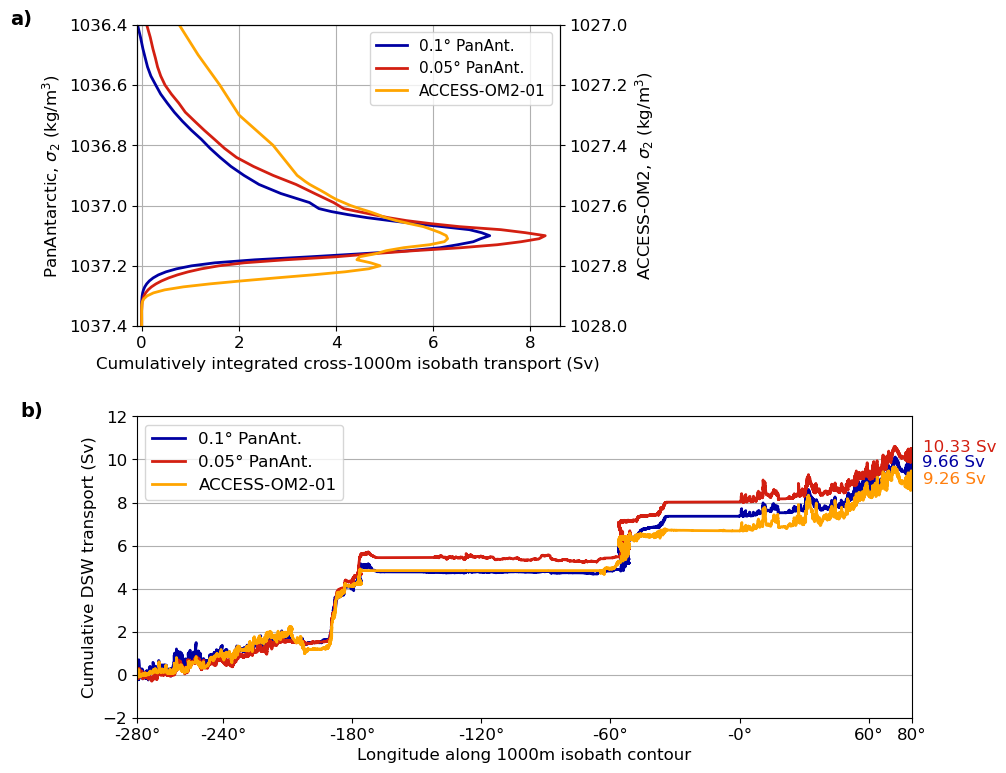

In [81]:
import matplotlib.gridspec as gridspec
plt.rcParams['font.size'] = 12

colors = {'Control_pan01': '#0000a2',
          'Control_pan005': '#d31f11',
          'Control_access': 'orange'}
#colors = {'Control_pan005': '#7CC4FF', 'Control_pan01' : '#339E09',  'Control_access': '#332288'} #
colors_text = {'Control_pan01': '#0000a2', 'Control_pan005' : '#d31f11',  'Control_access': 'tab:orange'}
line_offsets = {'Control_pan01': 0, 'Control_access':0, 'Control_pan005': 1.5}

# --- Create figure and flexible grid ---
fig = plt.figure(figsize=(10, 9))

# 2 rows, 2 columns grid
# bottom plot spans both columns (full width)
# top plot only uses first column (narrower)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1.5, 1], hspace=0.3)

# --- Top plot (panel a) occupies only the first column (narrower)
ax1 = fig.add_subplot(gs[0, 0])
ax1b = ax1.twinx()  # secondary y-axis on same panel

# --- Bottom plot (panel b) spans both columns (full width)
ax2 = fig.add_subplot(gs[1, :])

# ====================================================
# PANEL (a): Density profiles (PanAntarctic vs ACCESS)
# ====================================================

name = sector_names[0]  # "Circumpolar"

sector_pan01_control[0].plot(ax=ax1, y='rho2_l',
                             color=colors['Control_pan01'], linestyle='-',
                             linewidth=linewidths['control'], label="0.1° PanAnt.")

sector_pan005_control[0].plot(ax=ax1, y='rho2_l',
                              color=colors['Control_pan005'], linestyle='-',
                              linewidth=linewidths['control'], label="0.05° PanAnt.")

ax1.set_ylim(1037.4, 1036.4)
ax1.set_xlim(xlims_ctrlmelt[name])
ax1.set_ylabel(r'PanAntarctic, $\sigma_2$ (kg/m$^3$)')
ax1.grid()
ax1.set_xlabel("Cumulatively integrated cross-1000m isobath transport (Sv)")

sector_access_control[0].plot(ax=ax1b, y='isopycnal_bins',
                              color=colors['Control_access'], linestyle='-',
                              linewidth=linewidths['control'], label="ACCESS-OM2-01")

ax1b.set_ylim(1028.0, 1027.0)
ax1b.set_ylabel(r'ACCESS-OM2, $\sigma_2$ (kg/m$^3$)')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax1b.get_legend_handles_labels()
ax1b.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=11)

ax1.text(-0.3, 1.05, 'a)', transform=ax1.transAxes,
         ha='left', va='top', fontsize=14, fontweight='bold')

ax1.set_title("")
ax1b.set_title("")


# ====================================================
# PANEL (b): Cumulative transport vs longitude
# ====================================================

linestyles = {'Control_pan01': '-', 
              'Control_pan005': '-',
              'Control_access': '-'}
labels = {'Control_pan01': '0.1° PanAnt.',
          'Control_pan005': '0.05° PanAnt.',
          'Control_access': 'ACCESS-OM2-01'}
#line_offsets = {'Control_pan01': -1, 'Control_access': 0, 'Control_pan005': 1}

for key, array, res in zip(
    ['Control_pan01', 'Control_pan005', 'Control_access'],
    [pan01_cont_cumsum, pan005_cont_cumsum, access_cont_cumsum],
    ['01deg', '005deg', 'access']
):
    lon_vals = contour_data[res]['lon']
    offset = 0 if 'pan01' in key else -0.4
    ax2.plot(lon_vals, array, label=labels[key],
             color=colors[key], linestyle=linestyles[key], linewidth=2)
    ax2.text(lon_vals[-1] + 5, offset + array[-1] + 0.3 * line_offsets[key],
             f"{array[-1].values:.2f} Sv", color=colors_text[key], fontsize=12)

ax2.set_ylabel('Cumulative DSW transport (Sv)', fontsize=12)
ax2.set_ylim(-2, 12)
ax2.set_xlim(-280, 80)
ax2.grid(axis='y')

res_ref = '01deg'
indices = distance_indices_all[res_ref]
x_ticks = contour_data[res_ref]['lon'].values[indices]
ax2.set_xticks(x_ticks)
ax2.set_xticklabels([f"{lon:.0f}°" for lon in x_ticks])
ax2.set_xlabel('Longitude along 1000m isobath contour', fontsize=12)
ax2.legend(loc='upper left')

ax2.text(-0.15, 1.05, 'b)', transform=ax2.transAxes,
         ha='left', va='top', fontsize=14, fontweight='bold')

# --- Save and show ---
fig.savefig("/g/data/g40/kc5856/thesis_figures/validation_DSWprofile_combined_newcolours.png",
            dpi=300, bbox_inches='tight')
plt.show()
